In [20]:
import numpy as np
from astropy.io import fits
import os, sys
import healpy as hp
from matplotlib import pyplot as plt
import treecorr
from astropy.coordinates import SkyCoord

In [3]:
os.listdir('.')

['random0_DR12v5_CMASS_South.fits',
 'galaxy_DR12v5_LOWZ_North.fits',
 'galaxy_DR12v5_CMASS_North.fits',
 '.DS_Store',
 'galaxy_DR12v5_CMASS_South.fits',
 'galaxy_DR12v5_LOWZ_South.fits',
 'random0_DR12v5_CMASS_North.fits',
 'HFI_SkyMap_353-psb-field-IQU_2048_R3.00_full.fits',
 'README.md',
 'HFI_Mask_GalPlane-apo2_2048_R2.00.fits',
 'play.ipynb',
 'HFI_Mask_PointSrc_2048_R2.00.fits']

In [4]:
with fits.open('HFI_Mask_PointSrc_2048_R2.00.fits') as hdu:
    header = hdu[1].header
    point_mask = hdu[1].data['F353'] * hdu[1].data['F545'] * hdu[1].data['F857']
    
print(point_mask.shape, np.sum(point_mask) / point_mask.size)
header

(50331648,) 0.9446877837181091


XTENSION= 'BINTABLE'           /Written by IDL:  Thu Dec 11 12:42:11 2014       
BITPIX  =                    8 /                                                
NAXIS   =                    2 /Binary table                                    
NAXIS1  =                    6 /Number of bytes per row                         
NAXIS2  =             50331648 /Number of rows                                  
PCOUNT  =                    0 /Random parameter count                          
GCOUNT  =                    1 /Group count                                     
TFIELDS =                    6 /Number of columns                               
COMMENT                                                                         
COMMENT  *** End of mandatory fields ***                                        
COMMENT                                                                         
EXTVER  =                    1 /Extension version                               
DATE    = '2014-12-11'      

In [5]:
with fits.open('HFI_Mask_GalPlane-apo2_2048_R2.00.fits') as hdu:
    header = hdu[1].header
    gal_mask = hdu[1].data['GAL040']
    
print(gal_mask.shape, np.sum(gal_mask) / gal_mask.size)
header

(50331648,) 0.33842329184214276


XTENSION= 'BINTABLE'           /Written by IDL:  Tue Dec  9 17:13:53 2014       
BITPIX  =                    8 /                                                
NAXIS   =                    2 /Binary table                                    
NAXIS1  =                   32 /Number of bytes per row                         
NAXIS2  =             50331648 /Number of rows                                  
PCOUNT  =                    0 /Random parameter count                          
GCOUNT  =                    1 /Group count                                     
TFIELDS =                    8 /Number of columns                               
COMMENT                                                                         
COMMENT  *** End of mandatory fields ***                                        
COMMENT                                                                         
EXTVER  =                    1 /Extension version                               
DATE    = '2014-12-09'      

In [6]:
mask = point_mask * gal_mask
print(mask.shape, np.sum(mask) / mask.size)

(50331648,) 0.33182088534037274


In [7]:
with fits.open('HFI_SkyMap_353-psb-field-IQU_2048_R3.00_full.fits') as hdul:
    Ivals = hdul[1].data['I_STOKES']
    header = hdul[1].header

print(Ivals.shape)
header

(50331648,)


XTENSION= 'BINTABLE'           /Written by IDL:  Fri Nov 10 11:13:28 2017       
BITPIX  =                    8 /                                                
NAXIS   =                    2 /Binary table                                    
NAXIS1  =                   12 /Number of bytes per row                         
NAXIS2  =             50331648 /Number of rows                                  
PCOUNT  =                    0 /Random parameter count                          
GCOUNT  =                    1 /Group count                                     
TFIELDS =                    3 /Number of columns                               
COMMENT                                                                         
COMMENT  *** End of mandatory fields ***                                        
COMMENT                                                                         
EXTVER  =                    1 /Extension version                               
DATE    = '2017-11-10'      

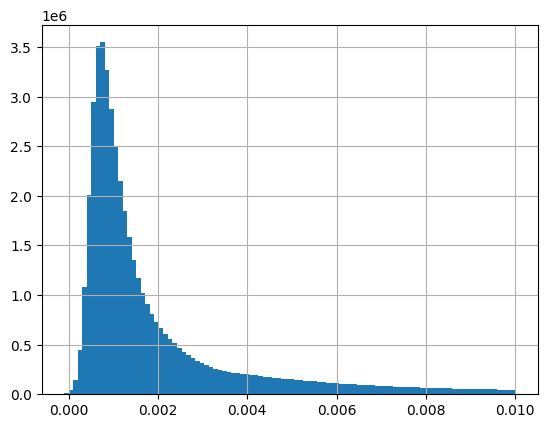

In [8]:
plt.figure()
plt.hist(Ivals, bins=100, range=(-1e-4, 1e-2))
plt.grid()
plt.show()
plt.close()

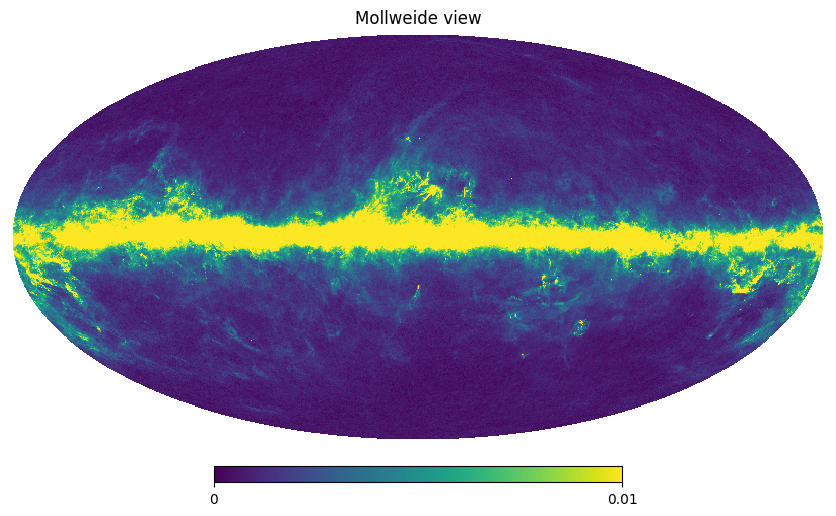

In [9]:
hp.mollview(Ivals, min=0, max=1e-2, nest=True)

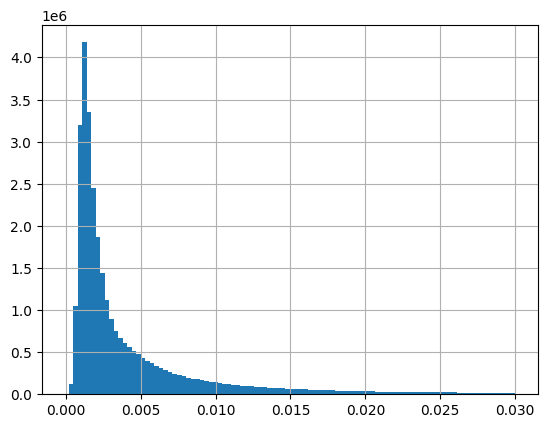

In [10]:
plt.figure()
plt.hist(mask + Ivals, bins=100, range=(-1e-4, 3e-2))
plt.grid()
plt.show()
plt.close()

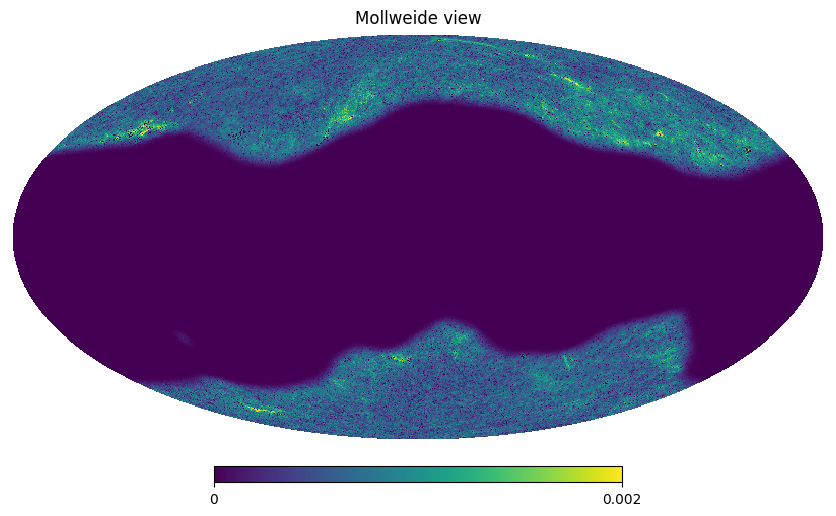

In [11]:
hp.mollview(Ivals * mask, min=0, max=2e-3, nest=True)

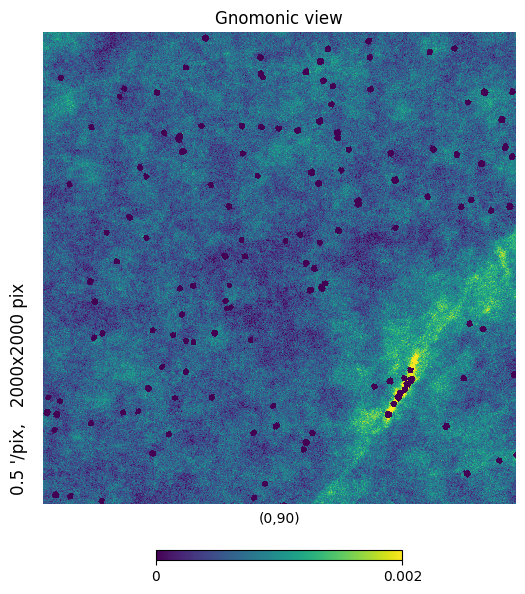

In [12]:
hp.gnomview(Ivals * mask, rot=[0, 90], reso=0.5, nest=True, min=0, max=2e-3, xsize=2000, ysize=2000)

In [23]:
nside = hp.npix2nside(Ivals.size)
l, b = hp.pix2ang(nside, np.arange(Ivals.size), nest=True, lonlat=True)
galactic = SkyCoord(l=l, b=b, frame='galactic', unit='deg')
icrs = galactic.icrs
ra = icrs.ra.deg
dec = icrs.dec.deg

ra, dec

(array([288.41076092, 288.40432261, 288.38356873, ..., 218.05009167,
        217.96740104, 217.99442558]),
 array([ 10.73235851,  10.76047693,  10.72154844, ..., -60.52197419,
        -60.53859542, -60.51302497]))

In [24]:
mapdata = treecorr.Catalog(ra=ra, dec=dec, k=Ivals * mask, ra_units='deg', dec_units='deg')

config = {'nbins': 20, 'min_sep': 0.5, 'max_sep': 200, 'sep_units': 'arcmin', 'bin_slop': 0.1, 'verbose': 2}

kk = treecorr.KKCorrelation(config=config)
kk.process(mapdata)

nbins = 20, min,max sep = 0.5..200 arcmin, bin_size = 0.299573
Starting process KK auto-correlations
Building KField
Starting 1024 jobs.
...............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

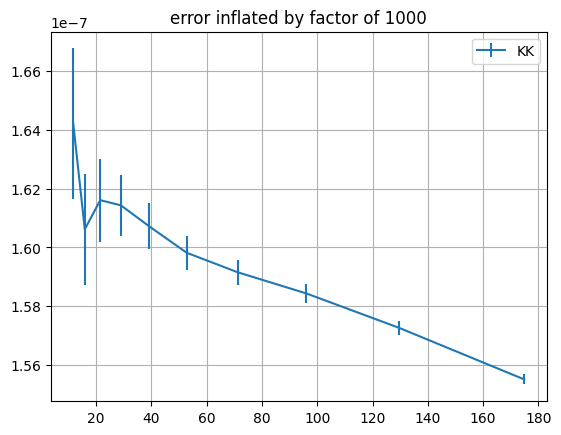

In [33]:
margin = 10
error_inflation = 1000

plt.figure()
plt.errorbar(np.exp(kk.meanlogr)[margin:], kk.xi[margin:], \
    yerr=np.sqrt(kk.varxi)[margin:]*error_inflation, label='KK')
plt.title(f'error inflated by factor of {error_inflation}')
# plt.loglog()
plt.legend()
plt.grid()
plt.show()
plt.close()

In [13]:
with fits.open("galaxy_DR12v5_CMASS_North.fits") as hdul:
    thead, tdata = hdul[1].header, hdul[1].data
    print(tdata.shape)
    
with fits.open("galaxy_DR12v5_CMASS_South.fits") as hdul:
    tdata = np.append(tdata, hdul[1].data)
    print(hdul[1].data.shape)
    print(tdata.shape)
    
with fits.open("random0_DR12v5_CMASS_North.fits") as hdul:
    rhead, rdata = hdul[1].header, hdul[1].data
    print(rdata.shape)
    
with fits.open("random0_DR12v5_CMASS_South.fits") as hdul:
    rdata = np.append(rdata, hdul[1].data)
    print(hdul[1].data.shape)
    print(rdata.shape)

(618806,)
(230831,)
(849637,)
(32151741,)
(11636252,)
(43787993,)


In [14]:
ZMIN, ZMAX = 0.43, 0.7

valid = (tdata['Z'] > ZMIN) & (tdata['Z'] < ZMAX)
tdata = tdata[valid]

valid = (rdata['Z'] > ZMIN) & (rdata['Z'] < ZMAX)
rdata = rdata[valid]

In [15]:
tw = tdata['WEIGHT_SYSTOT'] * (tdata['WEIGHT_CP'] + tdata['WEIGHT_NOZ'] - 1.0)
rw = rdata['WEIGHT_FKP']

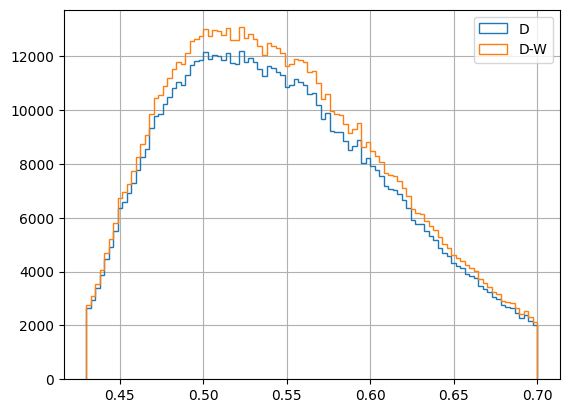

0.5472777 0.5857756


In [16]:
fig, ax = plt.subplots()
ax.hist(tdata['Z'], bins=100, range=(ZMIN, ZMAX), histtype='step', label='D')
ax.hist(tdata['Z'], bins=100, range=(ZMIN, ZMAX), histtype='step', label='D-W', weights=tw)
plt.legend()
plt.grid()
plt.show()
plt.close()

print(np.mean(tdata['Z']), np.mean(tdata['Z'] * tw))

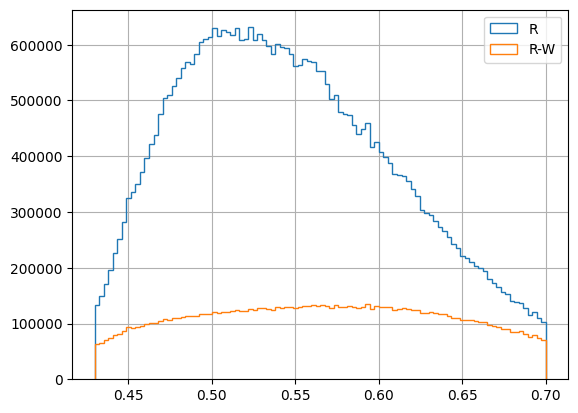

In [17]:
fig, ax = plt.subplots()
ax.hist(rdata['Z'], bins=100, range=(ZMIN, ZMAX), histtype='step', label='R')
ax.hist(rdata['Z'], bins=100, range=(ZMIN, ZMAX), histtype='step', label='R-W', weights=rw)
plt.legend()
plt.grid()
plt.show()
plt.close()

Make `treecorr` "N"-type catalog (for number counts, the kind used for galaxy positions). Also compute a autocorrelation as a sanity check. *Do not run this cell without commenting out the `process` unless you really want them, because this cell takes a while to run (~half an hour on Shubh's laptop).*

In [18]:
data = treecorr.Catalog(ra=tdata['RA'], dec=tdata['DEC'], w=tw, ra_units='deg', dec_units='deg')
randoms = treecorr.Catalog(ra=rdata['RA'], dec=rdata['DEC'], w=rw, ra_units='deg', dec_units='deg')

config = {'nbins': 20, 'min_sep': 0.5, 'max_sep': 200, 'sep_units': 'arcmin', 'bin_slop': 0.1, 'verbose': 2}

dd = treecorr.NNCorrelation(config)
dr = treecorr.NNCorrelation(config)
rr = treecorr.NNCorrelation(config)
dd.process(data)
dr.process(data,randoms)
rr.process(randoms)
xi, varxi = dd.calculateXi(rr, dr)

nbins = 20, min,max sep = 0.5..200 arcmin, bin_size = 0.299573
nbins = 20, min,max sep = 0.5..200 arcmin, bin_size = 0.299573
nbins = 20, min,max sep = 0.5..200 arcmin, bin_size = 0.299573
Starting process NN auto-correlations
Building NField
Starting 1024 jobs.
.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

/Users/shubh/miniconda3/envs/lim/lib/python3.9/site-packages/treecorr/util.py:665: FutureWarning: Use of keyword-only arguments as positional arguments is deprecated in the function calculateXi. The following parameters now require an explicit keyword name: ['rr', 'dr']
  warnings.warn(


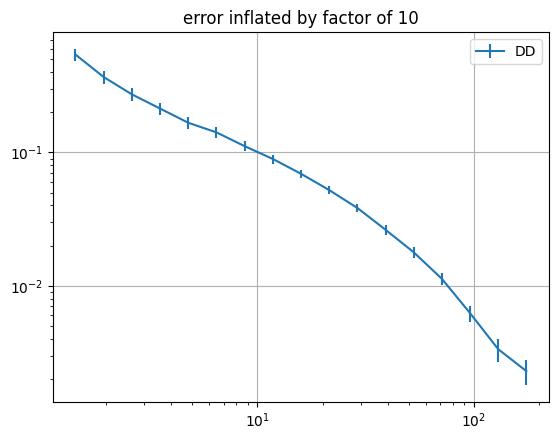

In [19]:
margin = 3
error_inflation = 10

plt.figure()
plt.errorbar(np.exp(dd.meanlogr)[margin:], xi[margin:], \
    yerr=np.sqrt(varxi)[margin:]*error_inflation, label='DD')
plt.title(f'error inflated by factor of {error_inflation}')
plt.loglog()
plt.legend()
plt.grid()
plt.show()
plt.close()

In [34]:
# get a cross correlation between the two maps

config = {'nbins': 10, 'min_sep': 20, 'max_sep': 200, 'sep_units': 'arcmin', 'bin_slop': 0.1, 'verbose': 2}

dk = treecorr.NKCorrelation(config)
rk = treecorr.NKCorrelation(config)
dk.process(data, mapdata)
rk.process(randoms, mapdata)

xi, varxi = dk.calculateXi(rk)

nbins = 10, min,max sep = 20..200 arcmin, bin_size = 0.230259
nbins = 10, min,max sep = 20..200 arcmin, bin_size = 0.230259
Starting process NK cross-correlations
Building NField
Building KField
Starting 1024 jobs.
.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

/Users/shubh/miniconda3/envs/lim/lib/python3.9/site-packages/treecorr/util.py:665: FutureWarning: Use of keyword-only arguments as positional arguments is deprecated in the function calculateXi. The following parameters now require an explicit keyword name: ['rk']
  warnings.warn(


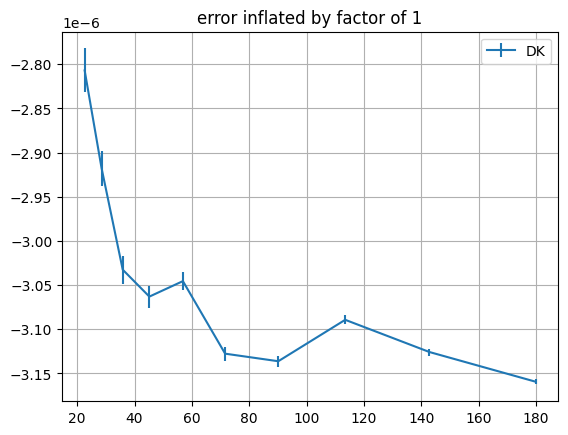

In [37]:
margin = 0
error_inflation = 1

plt.figure()
plt.errorbar(np.exp(dk.meanlogr)[margin:], xi[margin:], \
    yerr=np.sqrt(varxi)[margin:]*error_inflation, label='DK')
plt.title(f'error inflated by factor of {error_inflation}')
# plt.loglog()
plt.legend()
plt.grid()
plt.show()
plt.close()

In [43]:
from scipy import integrate
from scipy.special import legendre

xi_interp = lambda x: np.interp(x, np.exp(dk.meanlogr), xi)

l_values = np.arange(100, 1000, 100)
Cl = np.zeros_like(l_values, dtype=float)
for i, l in enumerate(l_values):
    print(i, l)
    Pl = legendre(l)
    integrand = lambda x: xi_interp(x) * Pl(np.cos(x))
    Cl[i] = integrate.quad(integrand, 0, np.pi)[0]

0 100
1 200
2 300
3 400
4 500
5 600
6 700
7 800
8 900


/Users/shubh/miniconda3/envs/lim/lib/python3.9/site-packages/scipy/special/_orthogonal.py:2479: RuntimeWarning: overflow encountered in scalar power
  kn = _gam(2 * n + 1) / _gam(n + 1)**2 / 2.0**n
/Users/shubh/miniconda3/envs/lim/lib/python3.9/site-packages/scipy/special/_orthogonal.py:2479: RuntimeWarning: invalid value encountered in scalar divide
  kn = _gam(2 * n + 1) / _gam(n + 1)**2 / 2.0**n
/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_61474/129208253.py:12: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Cl[i] = integrate.quad(integrand, 0, np.pi)[0]
/var/folde

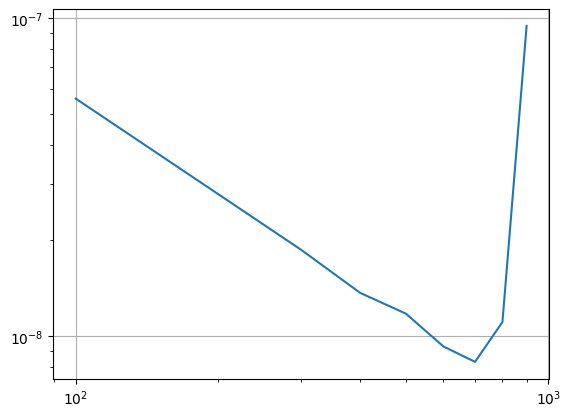

In [46]:
plt.figure()
plt.plot(l_values, -Cl)
plt.loglog()
plt.grid()
plt.show()
plt.close()